In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import time
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from keras import callbacks
import time
from models.lenet import LeNetModel
from models.resnet50 import ResNetModel
from models.ours import OurModel
from models.new_model import midModel

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 500
EPOCHS = 50

In [3]:
train_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-train.csv'
test_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-test.csv'

chunk_size = 10000
train_data_iter = pd.read_csv(train_file_path, chunksize=chunk_size)
train_data = pd.concat([chunk for chunk in tqdm(train_data_iter, desc='Loading training data')])
test_data_iter = pd.read_csv(test_file_path, chunksize=chunk_size)
test_data = pd.concat([chunk for chunk in tqdm(test_data_iter, desc='Loading test data')])

# Data dimensions and sizes
num_train_samples = train_data.shape[0]
num_test_samples = test_data.shape[0]

# Prepare data
x_train = train_data.iloc[:, 1:].to_numpy().reshape((num_train_samples, 28, 28, 1))
x_test = test_data.iloc[:, 1:].to_numpy().reshape((num_test_samples, 28, 28, 1))
y_train = tf.keras.utils.to_categorical(train_data.iloc[:, 0], 62)  # 62 classes for EMNIST ByClass
y_test = tf.keras.utils.to_categorical(test_data.iloc[:, 0], 62)

# Integer labels for sparse categorical crossentropy
y_train_int = train_data.iloc[:, 0].to_numpy()
y_test_int = test_data.iloc[:, 0].to_numpy()

# Split the training data into training and validation sets
_, _, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_train, x_valid, y_train_int, y_valid_int = train_test_split(x_train, y_train_int, test_size=0.1, random_state=42)

# Prepare data for ResNet
x_train_resized = tf.image.resize(x_train, [32, 32])
x_valid_resized = tf.image.resize(x_valid, [32, 32])
x_test_resized = tf.image.resize(x_test, [32, 32])

Loading training data: 0it [00:00, ?it/s]

Loading training data: 70it [00:14,  4.74it/s]
Loading test data: 12it [00:02,  4.91it/s]


In [4]:
checkpoint_path_lenet = f"./checkpoints/checkpoints_lenet/weights.{int(time.time())}.hdf5"
checkpoint_path_resnet = f"./checkpoints/checkpoints_resnet/weights.{int(time.time())}.hdf5"
checkpoint_path_ours = f"./checkpoints/checkpoints_ours/weights.{int(time.time())}.hdf5"

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)
checkpoint_lenet = callbacks.ModelCheckpoint(filepath=checkpoint_path_lenet, monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_resnet = callbacks.ModelCheckpoint(filepath=checkpoint_path_resnet, monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_ours = callbacks.ModelCheckpoint(filepath=checkpoint_path_ours, monitor='val_loss', save_best_only=True, verbose=1)


In [5]:
# Initialize models
lenet_model = LeNetModel()
resnet_model = ResNetModel()
our_model = midModel()

# Compile models
lenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [6]:
history = []
training_time=[]

In [7]:
start_time = time.time()
history.append(lenet_model.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[reduce_lr, checkpoint_lenet]))
end_time = time.time()
training_time.append(end_time-start_time)

Epoch 1/50
1257/1257 [==============================] - ETA: 0s - loss: 0.6787 - accuracy: 0.7892
Epoch 1: val_loss improved from inf to 0.47029, saving model to ./checkpoints/checkpoints_lenet/weights.1716302170.hdf5
1257/1257 [==============================] - 10s 5ms/step - loss: 0.6787 - accuracy: 0.7892 - val_loss: 0.4703 - val_accuracy: 0.8372 - lr: 0.0010
Epoch 2/50
  26/1257 [..............................] - ETA: 5s - loss: 0.4638 - accuracy: 0.8402

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1249/1257 [============================>.] - ETA: 0s - loss: 0.4402 - accuracy: 0.8447
Epoch 2: val_loss improved from 0.47029 to 0.43058, saving model to ./checkpoints/checkpoints_lenet/weights.1716302170.hdf5
1257/1257 [==============================] - 5s 4ms/step - loss: 0.4402 - accuracy: 0.8447 - val_loss: 0.4306 - val_accuracy: 0.8477 - lr: 0.0010
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.4110 - accuracy: 0.8521
Epoch 3: val_loss improved from 0.43058 to 0.41182, saving model to ./checkpoints/checkpoints_lenet/weights.1716302170.hdf5
1257/1257 [==============================] - 5s 4ms/step - loss: 0.4110 - accuracy: 0.8521 - val_loss: 0.4118 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 4/50
1248/1257 [============================>.] - ETA: 0s - loss: 0.3954 - accuracy: 0.8561
Epoch 4: val_loss improved from 0.41182 to 0.40723, saving model to ./checkpoints/checkpoints_lenet/weights.1716302170.hdf5
1257/1257 [==============================] - 6s 5ms/s

In [8]:
start_time = time.time()
history.append(resnet_model.train(x_train_resized, y_train_int, validation_data=(x_valid_resized, y_valid_int), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[reduce_lr, checkpoint_resnet]))
end_time = time.time()
training_time.append(end_time-start_time)

Epoch 1/50
1257/1257 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.8087
Epoch 1: val_loss improved from inf to 0.44779, saving model to ./checkpoints/checkpoints_resnet/weights.1716302170.hdf5
1257/1257 [==============================] - 87s 52ms/step - loss: 0.6026 - accuracy: 0.8087 - val_loss: 0.4478 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 2/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3961 - accuracy: 0.8556
Epoch 2: val_loss improved from 0.44779 to 0.40442, saving model to ./checkpoints/checkpoints_resnet/weights.1716302170.hdf5
1257/1257 [==============================] - 66s 53ms/step - loss: 0.3960 - accuracy: 0.8556 - val_loss: 0.4044 - val_accuracy: 0.8538 - lr: 0.0010
Epoch 3/50
1257/1257 [==============================] - ETA: 0s - loss: 0.3681 - accuracy: 0.8635
Epoch 3: val_loss improved from 0.40442 to 0.40053, saving model to ./checkpoints/checkpoints_resnet/weights.1716302170.hdf5
1257/1257 [============================

In [9]:
start_time = time.time()
history.append(our_model.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[reduce_lr, checkpoint_ours]))
end_time = time.time()
training_time.append(end_time-start_time)

Epoch 1/50
1257/1257 [==============================] - ETA: 0s - loss: 0.6320 - accuracy: 0.7987
Epoch 1: val_loss improved from inf to 0.46639, saving model to ./checkpoints/checkpoints_ours/weights.1716302170.hdf5
1257/1257 [==============================] - 8s 5ms/step - loss: 0.6320 - accuracy: 0.7987 - val_loss: 0.4664 - val_accuracy: 0.8370 - lr: 0.0010
Epoch 2/50
1244/1257 [============================>.] - ETA: 0s - loss: 0.4334 - accuracy: 0.8463
Epoch 2: val_loss improved from 0.46639 to 0.43160, saving model to ./checkpoints/checkpoints_ours/weights.1716302170.hdf5
1257/1257 [==============================] - 5s 4ms/step - loss: 0.4332 - accuracy: 0.8464 - val_loss: 0.4316 - val_accuracy: 0.8461 - lr: 0.0010
Epoch 3/50
1253/1257 [============================>.] - ETA: 0s - loss: 0.4034 - accuracy: 0.8545
Epoch 3: val_loss improved from 0.43160 to 0.41126, saving model to ./checkpoints/checkpoints_ours/weights.1716302170.hdf5
1257/1257 [==============================] - 5s 4

In [10]:
loss_lenet, acc_lenet = lenet_model.evaluate(x_test, y_test_int)
loss_resnet, acc_resnet = resnet_model.evaluate(x_test_resized, y_test_int)
loss_ours, acc_ours = our_model.evaluate(x_test, y_test_int)

3636/3636 [==============================] - 5s 1ms/step - loss: 0.3657 - accuracy: 0.8681


In [30]:
from datetime import datetime
_time = datetime.strftime(datetime.today(), '%Y-%m-%d_%H-%M-%S')

In [34]:
results = {
    "Model": ["LeNet-5", "ResNet-50", "CNN"],
    "Loss": [loss_lenet, loss_resnet, loss_ours],
    "Accuracy": [acc_lenet, acc_resnet, acc_ours],
    "Training Time": training_time
}
result_path = './results'
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_{_time}.csv', index=False)

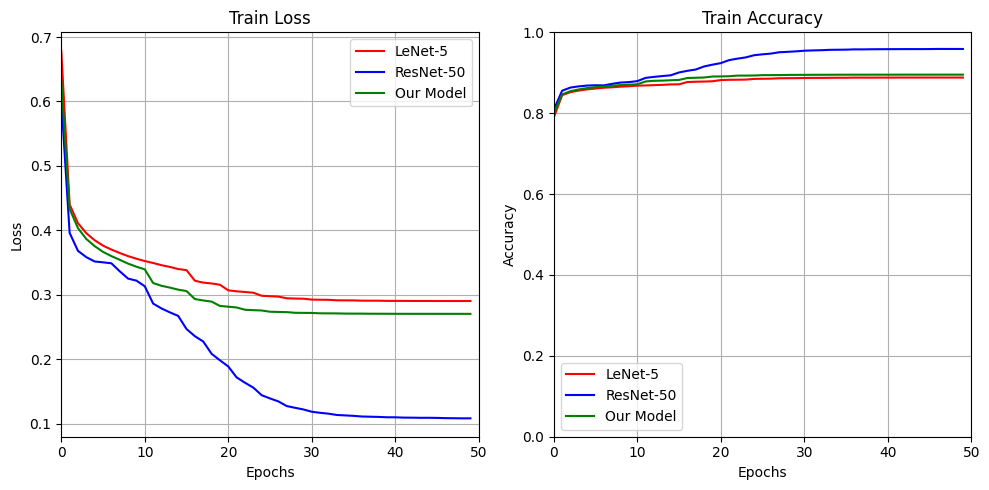

In [27]:
colors = ["red", "blue", "green"]

plt.figure(figsize=(10, 5))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_{_time}.png")
plt.show()

In [28]:
# training_time.append("")
results = {
    "Model": ["LeNet-5", "ResNet-50", "Our Model", "Wavemix-256[6]"],
    "Loss": [loss_lenet, loss_resnet, loss_ours, 0],
    "Accuracy": [acc_lenet, acc_resnet, acc_ours, 0.8842],
    "Training Time": training_time
}
results_df = pd.DataFrame(results)

/tmp/ipykernel_1732571/891141831.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")


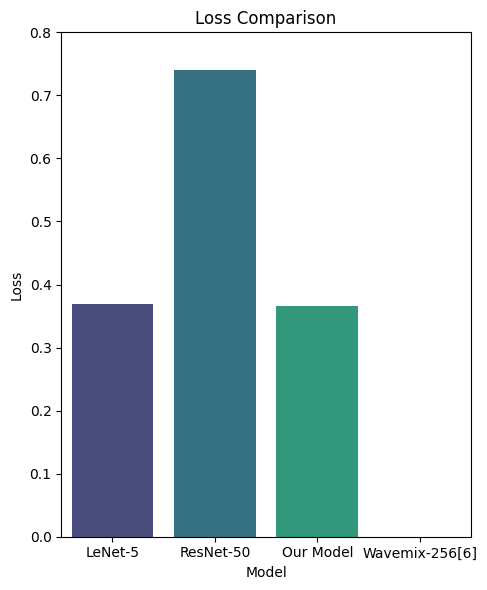

/tmp/ipykernel_1732571/891141831.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")


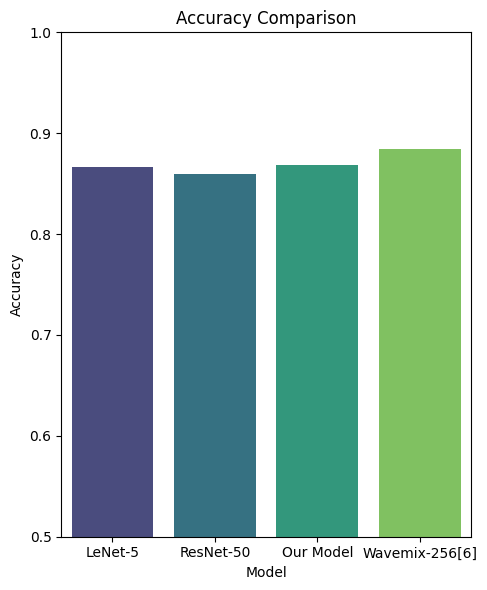

/tmp/ipykernel_1732571/891141831.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")


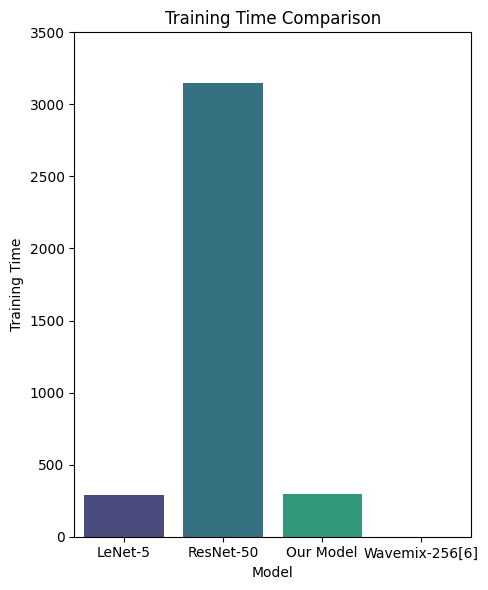

In [29]:
import seaborn as sns


result_path = './results'
metrics = ["Loss", "Accuracy", "Training Time"]
limits = [[0,0.8], [0.5,1.0], [0,3500]]
for metric, y_limit in zip(metrics, limits):
    plt.figure(figsize=(5, 6))
    sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.ylim(y_limit)
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_{_time}.png')
    plt.show()


In [22]:
our_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 6)         60        
                                                                 
 average_pooling2d_2 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 16)        880       
                                                                 
 average_pooling2d_3 (Avera  (None, 6, 6, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 120)         17400     
                                                                 
 flatten_1 (Flatten)         (None, 1920)             